Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [25]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import math

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [6]:
test_labels

array([3, 6, 4, ..., 6, 9, 0], dtype=int32)

In [18]:
print (test_labels[:,None])
print (test_labels[:,None].shape)

[[3]
 [6]
 [4]
 ..., 
 [6]
 [9]
 [0]]
(10000, 1)


In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

# We're first going to train a multinomial logistic regression using stochastic gradient descent training.

In [37]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Loss function
  logits = tf.matmul(tf_train_dataset, weights) + biases
     # original loss function
  unregularized_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)

     # regulariztion term, take the L2 loss of each of the weight tensors,
     # here we have only 1 weight tensor weights,
     # then sum them and multiply by a hyper-parameter beta.
     # tried different value for beta, 0.0001. 0.001, 0.002, 0.003, 0.004, 0.005 and 0.01, 
     # 0.002 and 0.003 are the best
  beta = 0.004
  l2_loss = beta * tf.nn.l2_loss(weights)
      
     # total loss is the sum of the orignal loss and l2 loss
  total_loss = tf.add(unregularized_loss, l2_loss)

  # Training computation.
  
  loss = tf.reduce_mean(total_loss)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

now let's run it:

In [38]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 27.728315
Minibatch accuracy: 12.5%
Validation accuracy: 14.4%
Minibatch loss at step 500: 2.167126
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 1000: 0.764433
Minibatch accuracy: 82.8%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 0.672192
Minibatch accuracy: 85.2%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 0.590772
Minibatch accuracy: 87.5%
Validation accuracy: 81.9%
Minibatch loss at step 2500: 0.694861
Minibatch accuracy: 81.2%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.558670
Minibatch accuracy: 88.3%
Validation accuracy: 81.5%
Test accuracy: 88.1%


# Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes.

Initialized
Minibatch loss at step 0: 637.093384
Minibatch accuracy: 7.8%
Validation accuracy: 14.4%
Minibatch loss at step 500: 322.028198
Minibatch accuracy: 78.9%
Validation accuracy: 79.1%
Minibatch loss at step 1000: 294.682770
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 276.338593
Minibatch accuracy: 82.8%
Validation accuracy: 82.0%
Minibatch loss at step 2000: 265.276245
Minibatch accuracy: 84.4%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 249.993240
Minibatch accuracy: 82.0%
Validation accuracy: 83.0%
Minibatch loss at step 3000: 235.778641
Minibatch accuracy: 87.5%
Validation accuracy: 82.8%
Test accuracy: 89.7%


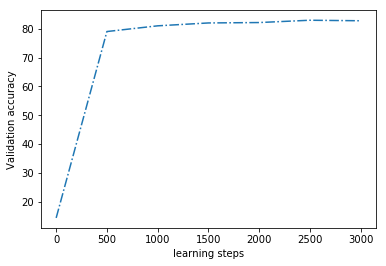

In [48]:
batch_size = 128
relu_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, relu_nodes]))
  biases1 = tf.Variable(tf.zeros([relu_nodes]))
  
  weights2 = tf.Variable(
    tf.truncated_normal([relu_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Loss function
  logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
  hidden = tf.nn.relu(logits1)
  logits2 = tf.matmul(hidden, weights2) + biases2
     # original loss function
  unregularized_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits2)

     # regulariztion term, take the L2 loss of each of the weight tensors,
     # here we have only 1 weight tensor weights,
     # then sum them and multiply by a hyper-parameter beta.
     # tried different value for beta, 0.002, 0.003, 0.004, 0.0045 and 0.006, 0.004 is the best
     
  beta = 0.001
  l2_loss = beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
      
     # total loss is the sum of the orignal loss and l2 loss
  total_loss = tf.add(unregularized_loss, l2_loss)

  # Training computation.
  loss = tf.reduce_mean(total_loss)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits2)
    
  valid_logits1 = tf.matmul(tf_valid_dataset, weights1) + biases1
  valid_hidden = tf.nn.relu(valid_logits1)
  valid_logits2 = tf.matmul(valid_hidden, weights2) + biases2
  valid_prediction = tf.nn.softmax(valid_logits2)
    
  test_logits1 = tf.matmul(tf_test_dataset, weights1) + biases1
  test_hidden = tf.nn.relu(test_logits1)
  test_logits2 = tf.matmul(test_hidden, weights2) + biases2
  test_prediction = tf.nn.softmax(test_logits2)

# let's run it:
num_steps = 3001
valid_accuracy = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      valid_accuracy1 = accuracy(valid_prediction.eval(), valid_labels)
      valid_accuracy.append(valid_accuracy1)
      print("Validation accuracy: %.1f%%" % valid_accuracy1)
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

xx = np.arange(len(valid_accuracy))
x_axis = [x*500 for x in xx]
plt.plot(x_axis, valid_accuracy, '-.')
plt.xlabel("learning steps")
plt.ylabel("Validation accuracy")
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Training a smaller training set by a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes, the model is the same as in problem 1. It could be seen that Minibatch accuracy is 100%, but validation and test accuracy is low. As the model are learning more steps, the loss decreases, but the validation accuray is kept constant. 

Initialized
Minibatch loss at step 0: 641.999023
Minibatch accuracy: 10.9%
Validation accuracy: 23.1%
Minibatch loss at step 500: 299.494049
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 1000: 284.888031
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 1500: 270.993591
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 2000: 257.776886
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 2500: 245.204010
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 3000: 233.245590
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Test accuracy: 75.8%


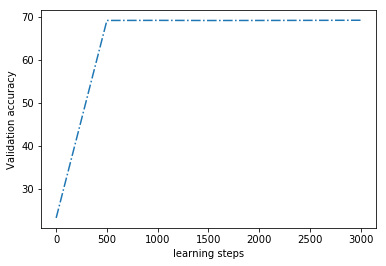

In [50]:
num_steps = 3001
valid_accuracy = []
subset = 1000 #use only 1000 training set
train_dataset_smaller = train_dataset[0:subset, :]
train_labels_smaller = train_labels[0:subset, :]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_smaller.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_smaller[offset:(offset + batch_size), :]
    batch_labels = train_labels_smaller[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      valid_accuracy1 = accuracy(valid_prediction.eval(), valid_labels)
      valid_accuracy.append(valid_accuracy1)
      print("Validation accuracy: %.1f%%" % valid_accuracy1)
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

xx = np.arange(len(valid_accuracy))
x_axis = [x*500 for x in xx]
plt.plot(x_axis, valid_accuracy, '-.')
plt.xlabel("learning steps")
plt.ylabel("Validation accuracy")
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Initialized
Minibatch loss at step 0: 1443.192871
Minibatch accuracy: 10.9%
Validation accuracy: 16.7%
Minibatch loss at step 500: 331.351868
Minibatch accuracy: 77.3%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 290.583130
Minibatch accuracy: 84.4%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 272.504150
Minibatch accuracy: 87.5%
Validation accuracy: 80.2%
Minibatch loss at step 2000: 263.054352
Minibatch accuracy: 89.8%
Validation accuracy: 80.4%
Minibatch loss at step 2500: 246.267349
Minibatch accuracy: 88.3%
Validation accuracy: 80.3%
Minibatch loss at step 3000: 233.097748
Minibatch accuracy: 90.6%
Validation accuracy: 80.3%
Test accuracy: 86.8%


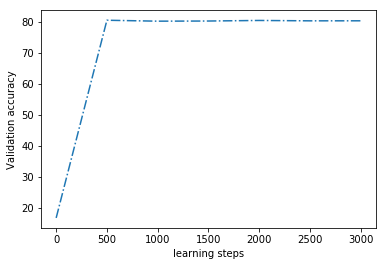

In [12]:
batch_size = 128
relu_nodes1 = 1024
dropout = 0.1  # Dropout, probability to keep unit

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
      'w1': tf.Variable(tf.truncated_normal([image_size * image_size, relu_nodes1])),
      'out': tf.Variable(tf.truncated_normal([relu_nodes1, num_labels])),
  }
      
  biases = {
      'b1': tf.Variable(tf.zeros([relu_nodes1])),
      'out': tf.Variable(tf.zeros([num_labels])),
  }

  # Loss function
    #Hidden layer with RELU activation
  layer1 = tf.matmul(tf_train_dataset, weights['w1']) + biases['b1']
  layer1 = tf.nn.relu(layer1)
     #apply dropout to the hedden layer, do NOT apply drop out for the out_layer
  layer1_dropout = tf.nn.dropout(layer1, dropout)
     #output layer with linear activation'
  out_layer = tf.matmul(layer1_dropout, weights['out']) + biases['out']
       
     # original loss function
  unregularized_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=out_layer)

     # regulariztion term, take the L2 loss of each of the weight tensors,
     # here we have only 1 weight tensor weights,
     # then sum them and multiply by a hyper-parameter beta.
     # tried different value for beta, 0.002, 0.003, 0.004, 0.0045 and 0.006, 0.004 is the best
     
  beta = 0.001
     #ls_loss, regularize only weights, do NOT regularize biaes
  l2_loss = beta * (tf.nn.l2_loss(weights['w1']) + 
                    tf.nn.l2_loss(weights['out'])
                   )
      
     # total loss is the sum of the orignal loss and l2 loss
  total_loss = tf.add(unregularized_loss, l2_loss)

  # Training computation.
  loss = tf.reduce_mean(total_loss)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(out_layer) 
    
  valid_layer1 = tf.matmul(tf_valid_dataset, weights['w1']) + biases['b1']
  valid_layer1 = tf.nn.relu(valid_layer1)
  valid_layer_out = tf.matmul(valid_layer1, weights['out']) + biases['out']
  valid_prediction = tf.nn.softmax(valid_layer_out)
    
  test_layer1 = tf.matmul(tf_test_dataset, weights['w1']) + biases['b1']
  test_layer1 = tf.nn.relu(test_layer1)
  test_layer_out = tf.matmul(test_layer1, weights['out']) + biases['out']
  test_prediction = tf.nn.softmax(test_layer_out)

    
# now let's run it:     
num_steps = 3001
valid_accuracy = []
subset = 1000 #use only 1000 training set
train_dataset_smaller = train_dataset[0:subset, :]
train_labels_smaller = train_labels[0:subset, :]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_smaller.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_smaller[offset:(offset + batch_size), :]
    batch_labels = train_labels_smaller[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      valid_accuracy1 = accuracy(valid_prediction.eval(), valid_labels)
      valid_accuracy.append(valid_accuracy1)
      print("Validation accuracy: %.1f%%" % valid_accuracy1)
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

xx = np.arange(len(valid_accuracy))
x_axis = [x*500 for x in xx]
plt.plot(x_axis, valid_accuracy, '-.')
plt.xlabel("learning steps")
plt.ylabel("Validation accuracy")
plt.show()

By introducing Dropout, and decreasing the parameter 'dropout' the Minibatch accuracy is approaching the validation accuracy, meaning overfitting is reduced. Meanwhile, the test accuracy is increasing.   

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized
Minibatch loss at step 0: 3.357512
Minibatch accuracy: 14.8%
Validation accuracy: 20.1%
Minibatch loss at step 500: 1.536435
Minibatch accuracy: 85.2%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 1.343784
Minibatch accuracy: 87.5%
Validation accuracy: 85.1%
Minibatch loss at step 1500: 1.323500
Minibatch accuracy: 88.3%
Validation accuracy: 86.0%
Minibatch loss at step 2000: 1.180325
Minibatch accuracy: 91.4%
Validation accuracy: 86.5%
Minibatch loss at step 2500: 1.267073
Minibatch accuracy: 87.5%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 1.103201
Minibatch accuracy: 91.4%
Validation accuracy: 87.3%
Minibatch loss at step 3500: 1.107416
Minibatch accuracy: 92.2%
Validation accuracy: 87.9%
Minibatch loss at step 4000: 1.044433
Minibatch accuracy: 90.6%
Validation accuracy: 87.7%
Minibatch loss at step 4500: 1.053688
Minibatch accuracy: 89.1%
Validation accuracy: 87.9%
Minibatch loss at step 5000: 1.087368
Minibatch accuracy: 85.9%
Validation accurac

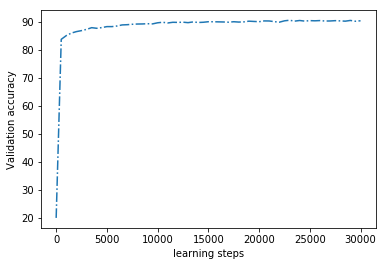

In [29]:
batch_size = 128
relu_nodes1 = 1024
relu_nodes2 = 300
dropout = 0.1  # Dropout, probability to keep unit

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
      'w1': tf.Variable(tf.truncated_normal([image_size * image_size, relu_nodes1], 
                                            stddev = math.sqrt(2.0/(image_size * image_size)))),
      'w2': tf.Variable(tf.truncated_normal([relu_nodes1, relu_nodes2], stddev = math.sqrt(2.0/relu_nodes1))),
      'out': tf.Variable(tf.truncated_normal([relu_nodes2, num_labels], stddev = math.sqrt(2.0/relu_nodes2))),
  }
      
  biases = {
      'b1': tf.Variable(tf.zeros([relu_nodes1])),
      'b2': tf.Variable(tf.zeros([relu_nodes2])),
      'out': tf.Variable(tf.zeros([num_labels])),
  }

  # Loss function
    #Hidden layer with RELU activation
  layer1 = tf.matmul(tf_train_dataset, weights['w1']) + biases['b1']
  layer1 = tf.nn.relu(layer1)
    #Hidden layer with RELU activation
  layer2 = tf.matmul(layer1, weights['w2']) + biases['b2']
  layer2 = tf.nn.relu(layer2)
    #output layer with linear activation'
  out_layer = tf.matmul(layer2, weights['out']) + biases['out']
  
     #apply dropout
  #logits2_dropout = tf.nn.dropout(logits2, dropout)
     # original loss function
  unregularized_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=out_layer)

     # regulariztion term, take the L2 loss of each of the weight tensors,
     # here we have only 1 weight tensor weights,
     # then sum them and multiply by a hyper-parameter beta.
     # tried different value for beta, 0.002, 0.003, 0.004, 0.0045 and 0.006, 0.004 is the best
     
  beta = 0.001
     #ls_loss, regularize only weights, do NOT regularize biaes
  l2_loss = beta * (tf.nn.l2_loss(weights['w1']) + 
                    tf.nn.l2_loss(weights['w2']) +
                    tf.nn.l2_loss(weights['out'])
                   )
      
     # total loss is the sum of the orignal loss and l2 loss
  total_loss = tf.add(unregularized_loss, l2_loss)

  # Training computation.
  loss = tf.reduce_mean(total_loss)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  #global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.05, global_step, 3000, 0.86, staircase = True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(out_layer) 
    
  valid_layer1 = tf.matmul(tf_valid_dataset, weights['w1']) + biases['b1']
  valid_layer1 = tf.nn.relu(valid_layer1)
  valid_layer2 = tf.matmul(valid_layer1, weights['w2']) + biases['b2']
  valid_layer2 = tf.nn.relu(valid_layer2)
  valid_layer_out = tf.matmul(valid_layer2, weights['out']) + biases['out']
  valid_prediction = tf.nn.softmax(valid_layer_out)
    
  test_layer1 = tf.matmul(tf_test_dataset, weights['w1']) + biases['b1']
  test_layer1 = tf.nn.relu(test_layer1)
  test_layer2 = tf.matmul(test_layer1, weights['w2']) + biases['b2']
  test_layer2 = tf.nn.relu(test_layer2)
  test_layer_out = tf.matmul(test_layer2, weights['out']) + biases['out']
  test_prediction = tf.nn.softmax(test_layer_out)

    
# now let's run it:     
num_steps = 30001
valid_accuracy = []
#subset = 1000 #use only 1000 training set
#train_dataset_smaller = train_dataset[0:subset, :]
#train_labels_smaller = train_labels[0:subset, :]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      
      valid_accuracy1 = accuracy(valid_prediction.eval(), valid_labels)
      valid_accuracy.append(valid_accuracy1)
      print("Validation accuracy: %.1f%%" % valid_accuracy1)
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

xx = np.arange(len(valid_accuracy))
x_axis = [x*500 for x in xx]
plt.plot(x_axis, valid_accuracy, '-.')
plt.xlabel("learning steps")
plt.ylabel("Validation accuracy")
plt.show()

# note:
Adding **stddev** terms to the **weights** greatly increased the accuracy(in 3001 steps, from 61% to 93%).
